# Breast Cancer Prediction

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

tf.get_logger().setLevel('ERROR')

In [4]:
import os
DATA_DIR = "/Users/shankar/dev/data/competitions/uci/breast-cancer-wisconsin/"
DATA_FILE = os.path.join(DATA_DIR, "breast_cancer.csv")

In [5]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
data_file = tf.keras.utils.get_file(DATA_FILE, DATASET_URL)
col_names = ["id", "clump_thickness", "un_cell_size", "un_cell_shape", "marginal_adheshion", "single_eph_cell_size", "bare_nuclei", "bland_chromatin", "normal_nucleoli", "mitoses", "class"]
df = pd.read_csv(data_file, names=col_names, header=None)

24576/19889 [=====================================] - 0s 12us/step


In [6]:
df.head()

,id,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [8]:
df.pop("id")

In [9]:
df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

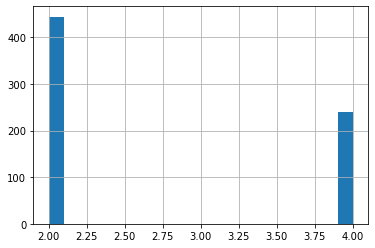

In [10]:
df['class'].hist(bins=20) 

In [11]:
df['class'] = np.where(df['class'] == 2, 0, 1)

In [12]:
train, test = train_test_split(df, test_size = 0.2)

In [13]:
train_stats = train.describe()
train_stats

,clump_thickness,un_cell_size,un_cell_shape,marginal_adheshion,single_eph_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,4.456044,3.217949,3.304029,2.910256,3.307692,3.716117,3.483516,2.994505,1.639194,0.366300
std,2.825001,3.080886,3.006882,2.900365,2.274835,3.738959,2.416439,3.114625,1.784706,0.482235
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,2.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,8.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


In [14]:
train_stats.pop('class')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
clump_thickness,546.0,4.456044,2.825001,1.0,2.0,4.0,6.0,10.0
un_cell_size,546.0,3.217949,3.080886,1.0,1.0,1.0,5.0,10.0
un_cell_shape,546.0,3.304029,3.006882,1.0,1.0,2.0,5.0,10.0
marginal_adheshion,546.0,2.910256,2.900365,1.0,1.0,1.0,4.0,10.0
single_eph_cell_size,546.0,3.307692,2.274835,1.0,2.0,2.0,4.0,10.0
bare_nuclei,546.0,3.716117,3.738959,1.0,1.0,1.0,8.0,10.0
bland_chromatin,546.0,3.483516,2.416439,1.0,2.0,3.0,5.0,10.0
normal_nucleoli,546.0,2.994505,3.114625,1.0,1.0,1.0,4.0,10.0
mitoses,546.0,1.639194,1.784706,1.0,1.0,1.0,1.0,10.0


In [15]:
train_Y = train.pop("class")
test_Y = test.pop("class")

In [16]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [17]:
norm_train_X = norm(train)
norm_test_X = norm(test)

## Create Tensorflow Datasets

In [19]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (norm_train_X.values, train_Y.values)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (norm_test_X.values, test_Y.values)
)

In [20]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)
test_dataset = test_dataset.batch(batch_size=batch_size)

In [21]:
a = enumerate(train_dataset)
print(len(list(a)))

18


## Define the Model

In [28]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

In [29]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

## Evaluate Untrained Model

In [30]:
outputs = model(norm_test_X.values)
loss_value = loss_object(y_true=test_Y.values, y_pred=outputs)
print("Loss before training %.4f" % loss_value.numpy())

Loss before training 0.6854


In [31]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

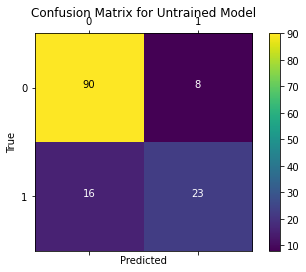

In [32]:
plot_confusion_matrix(test_Y.values, tf.round(outputs), title='Confusion Matrix for Untrained Model')